<a href="https://colab.research.google.com/github/Carlo-pien/Projet_ML_2_MA1/blob/master/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install einops
!pip install pytorch-lightning
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

     |████████████████████████████████| 525 kB 12.7 MB/s 
     |████████████████████████████████| 829 kB 45.3 MB/s 
     |████████████████████████████████| 132 kB 46.3 MB/s 
     |████████████████████████████████| 332 kB 48.5 MB/s 
     |████████████████████████████████| 596 kB 49.4 MB/s 
     |████████████████████████████████| 1.1 MB 48.6 MB/s 
     |████████████████████████████████| 271 kB 37.1 MB/s 
     |████████████████████████████████| 192 kB 14.6 MB/s 
     |████████████████████████████████| 160 kB 41.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=bba58ea7c43b3cba3890f6a8cea4c800863b1f67a09d10f70f6576442315775b
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exi

In [ ]:
! grep MemTotal /proc/meminfo


MemTotal:       13302924 kB


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from IPython import get_ipython  # type: ignore

# %% 
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


Importation of the different packages we will need 

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import numpy as np
import math
from sklearn.model_selection import KFold
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms as transforms
import albumentations.augmentations.transforms as tf
from torchvision.transforms import Compose
import albumentations as A
import torchvision.transforms.functional as TF
from einops import rearrange, reduce
import pytorch_lightning as pl
import cv2
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(1)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Projet_ML/')
#from Unet_model import Unet
from Unet_model_lightning import Lit_Net

## Loading the data :

In [ ]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def to_RGB(mask):
  return np.repeat(np.round(mask)[:, :, np.newaxis], 3, axis=2)

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [ ]:
# Loaded a set of images
root_dir = "/content/drive/MyDrive/Projet_ML/training/"
n = 100
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(n, len(files))
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])



Loading 100 images
satImage_100.png
Loading 100 images
satImage_100.png


Image size = 400,400
(400, 400, 3) (400, 400)


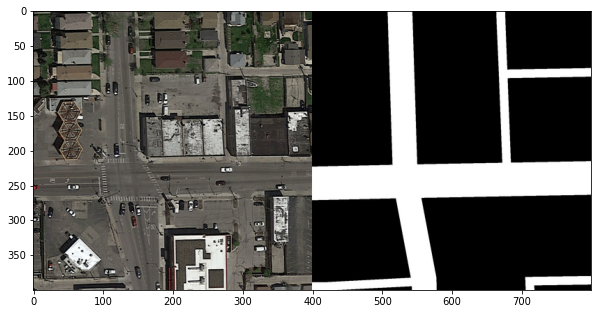

In [ ]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
print(imgs[0].shape, gt_imgs[0].shape)
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

We print here the different data types and the shape of our images

In [ ]:
print("data types of the datapoints : ", type(imgs[0]))
print("data type : ", imgs[0].dtype)
print("dimension of images : ", imgs[0].shape)
print("Number of images : ", len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]))
print("data types of the labels : ", type(gt_imgs[0]))
print("dimension of labels : ", gt_imgs[0].shape)
print("max label value : ", np.amax(gt_imgs[0]), "min label value : ", np.amin(gt_imgs[0]))

data types of the datapoints :  <class 'numpy.ndarray'>
data type :  float32
dimension of images :  (400, 400, 3)
Number of images :  100
data types of the labels :  <class 'numpy.ndarray'>
dimension of labels :  (400, 400)
max label value :  0.92941177 min label value :  0.0


Our dataset consists of 100 images of dimension 400 by 400 pixels, with 3 color chanels each.

Moreover, there is one label file per image, each consisting of a 400 by 400 array (one value per pixel), ranging from 0 to 1. These are the probabilities of a given pixel belonging to a road, i.e., the values we are trying to retrieve.

## Preparation of the dataset for classification :

First, we concatenate all images in a single torch Tensor with shape (images, channels, width, height), and the labels into a single torch Tensor with shape (masks, width, height). We then use these tensors to create our dataset and dataloader :

Below : Loading images into np.arrays

In [ ]:
data = []
for idx, img in enumerate(imgs) :
  data.append(img)

labels = []
for idx, mask in enumerate(gt_imgs) :
  labels.append(mask)


Definition of the Dataset class and the different transformations

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, images_np =  data, masks_np =labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.num_samples = np.array(data).shape[0]
        self.images_np = images_np
        self.masks_np = masks_np
        
    def __getitem__(self, index):        
        if self.transform:
            
            img1 = np.array(self.images_np)[index,:,:,:]
            msk1 = np.array(self.masks_np)[index,:,:]

            #Add a dimension to masks and reshape it to have correct input for transformation
            mask1 = np.expand_dims(msk1, axis = 0)
            
            mask1 = (rearrange(mask1, 'c h w -> h w c'))

            #Applying the transformations
            transformed = self.transform(image=img1, mask=mask1)
            image11 = rearrange(transformed['image'], 'h w c -> c h w')
            mask11 = rearrange(transformed['mask'], 'h w c -> c h w')
            mask11 = np.squeeze(mask11, axis = 0)

        #print("max label value : ", np.amax(y.numpy()), "min label value : ", np.amin(y.numpy()))
        return image11, mask11
    
    def __len__(self):
        return self.num_samples

#Defining the transformations
train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomSizedCrop(min_max_height=	[200,200], height = 400, width=400, p = 0.5),
        A.ShiftScaleRotate(p=0.5),
        A.Affine(shear=[-10, 10], scale=1.1, fit_output=False, p=.1),
        A.GaussNoise(var_limit=(.001, .03), p=.5),
        A.Blur(blur_limit=5., p=.2),
        A.ImageCompression(quality_lower=50, p=.2),
    ]
my_transform = A.Compose(train_transform)

dataset = CustomDataset(data, labels, transform=my_transform)
dataloader = DataLoader(dataset,
                        batch_size=4,
                        shuffle=True)

dataiter = iter(dataloader)
data_ = dataiter.next()

x, y = data_

print("shape of output", x.shape, y.shape)

shape of output torch.Size([4, 3, 400, 400]) torch.Size([4, 400, 400])


## First classifier :

The first classifier we build is modeled after Unet, an architecture for image segmentation. The motivations for choosing this architecture are explaiend in our report.

Essentially, Unet consists in a descending part, and an ascending part. The descending part is a series of pairs of convolutions, each followed by a pooling layer that allows to reduce the dimension of the input.

The ascending part is a series of pairs of convolutions, followed by deconvolutions that allow to increase back the size of the output, such that eachdeconvolution recieves a skip connection from the corresponding layer in the descending part.

Moreover, our model will perform batchnorm after each convolution.

As a consequence all we need to implement is

Define the model :

In [ ]:
l_unet = Lit_Net(in_chans=3, out_chans=1)

trainer = pl.Trainer(max_epochs=150,
                    progress_bar_refresh_rate=1,
                    gpus=1,
                    auto_scale_batch_size=True,
                    accumulate_grad_batches=1)

trainer.fit(l_unet, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | descending    | ModuleList        | 1.1 M 
1 | ascending     | ModuleList        | 3.0 M 
2 | pooling_layer | MaxPool2d         | 0     
3 | bottom        | DoubleConv        | 3.5 M 
4 | output_layer  | Conv2d            | 65    
5 | criterion     | BCEWithLogitsLoss | 0     
----------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.812    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Save the pretrained network in a file

In [ ]:
path = os.path.join('drive/MyDrive/Projet_ML/pretrained_models/unet_150epoch_model_from_scratch_all_transformations_arthur.pth')
torch.save(l_unet, path)



## Generating predictions

Test dataloader :

In [ ]:
# Loaded a set of images
root_dir = "/content/drive/MyDrive/Projet_ML/test_set_images/"

files = os.listdir(image_dir)
n = min(50, len(files))
print("Loading " + str(n) + " images")
test_imgs = [load_image(image_dir + files[i]) for i in range(50)]
print(files[0])


Get the trained model we saved before for our predictions

In [ ]:
path = os.path.join('drive/MyDrive/Projet_ML/pretrained_models/unet_150epoch_model_from_scratch_all_transformations_arthur.pth')
model = torch.load(path)
model.eval()

Lit_Net(
  (descending): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(12

generating predictions and storing the predicted masks in a list

In [ ]:
test_aug_downsize = A.RandomSizedCrop(min_max_height=	[608,608], height = 400, width=400, p = 1.)

root_dir_test = "/content/drive/MyDrive/Projet_ML/test_set_images/"
n_test = 50
files_test = os.listdir(root_dir_test)
files_test = [file for file in files_test if file.endswith('.png')]
n_test = min(n_test, len(files_test))
imgs_test = []
imgs_test_names = []
for i in range(n_test):
  imgs_test.append(test_aug_downsize(image=load_image(root_dir_test + files_test[i])))
  img_name = str(files_test[i])
  img_name = img_name.replace("test_", "")
  img_name = img_name.replace(".png", "")
  img_name = img_name.zfill(2)
  imgs_test_names.append(img_name)

generating predictions and storing the predicted masks in a list

In [ ]:
test_aug_upsize = A.RandomSizedCrop(min_max_height=	[400,400], height = 608, width=608, p = 1.)

preds = []
for i in range(n_test):
  y = model(rearrange(torch.unsqueeze(torch.Tensor(imgs_test[i]['image']), dim=0), 'b h w c -> b c h w'))
  y = rearrange(torch.squeeze(y, dim=0).to('cpu').detach().numpy(), 'c h w -> h w c')
  y = test_aug_upsize(image=y)
  preds.append(y)

creating a new list with only the relevant part of the masks (that is, the masks are dictionaries, so we evaluate them to get only the keys associated to the masks. 

In [ ]:
for_submission = []
for i, pred in enumerate(preds) :
  for_submission.append((preds[i]['image'].transpose(2, 0, 1)[0]))

saving the masks in a new directory

In [ ]:
from PIL import Image as im
path = os.path.join('/content/drive/MyDrive/Projet_ML/for_submission/')

for i, mask in enumerate(for_submission):
  name = imgs_test_names[i]
  mask = im.fromarray(255*mask)
  mask = mask.convert('RGB')
  mask.save(path+name+'.png')

Creation of the file for the submission on *AIcrowd*

In [ ]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df < foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = 1-patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


def create_submission():
  submission_filename = '/content/drive/MyDrive/Projet_ML/twentythree_submission.csv'
  image_filenames = []
  for i in range(1, 51):
      image_filename = '/content/drive/MyDrive/Projet_ML/for_submission/' + '%.2d' % i + '.png'
      image_filenames.append(image_filename)
  masks_to_submission(submission_filename, *image_filenames)

create_submission()